In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import dandelion as ddl
import os
import tools

sc.logging.print_header()

os.chdir(os.path.expanduser('/home/jovyan/Zach/scanpy/'))

scanpy==1.8.2 anndata==0.7.5 umap==0.5.1 numpy==1.19.4 scipy==1.5.2 pandas==1.2.3 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 leidenalg==0.8.2 pynndescent==0.5.2


In [2]:
ddl.logging.print_header()

dandelion==0.2.4 pandas==1.2.3 numpy==1.19.4 matplotlib==3.3.3 networkx==2.5 scipy==1.5.2


In [3]:
# just do naive only and split up each tissue
adata_list = []

samples = [#"LN", 
           "Men", 
           #"LN2", 
           "Men2"]
condition = ["naive"
            # , "VSV"
            ]
site_dict = {"LN": "LN", "Men": "Meninges", "LN2": "LN", "Men2": "Meninges"}
file_dict = {
    "LN_naive": "LN_naive",
    "Men_naive": "Men_naive",
    "LN2_naive": "PBS_LN",
    "Men2_naive": "PBS_HUB",
    "LN_VSV": "LN_VSV",
    "Men_VSV": "Men_VSV",
    "LN2_VSV": "VSV_LN_2",
    "Men2_VSV": "VSV_HUB",
}

for s in samples:
    for c in condition:
        adatax = sc.read_10x_h5(
            "../raw/"
            + s
            + "_"
            + c
            + "_outs/"
            + file_dict[s + "_" + c]
            + "_filtered_feature_bc_matrix.h5"
        )
        adatax.var_names_make_unique()
        adatax.obs["sample_id"] = s + "_" + c
        adatax.obs["condition"] = c
        adatax.obs["site"] = site_dict[s]
        adatax.obs_names = [
            file_dict[s + "_" + c] + "_" + n for n in adatax.obs_names
        ]
        ddl.pp.external.recipe_scanpy_qc(
            adatax,
            mito_startswith='mt-',
            max_genes=10000,
            min_genes=100,
            mito_cutoff=50,
            vdj_pattern=None,
        )
        adatax.layers['counts'] = adatax.X.copy()
        adata_list.append(adatax)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [4]:
adata = sc.concat(adata_list)
adata

AnnData object with n_obs × n_vars = 6137 × 29836
    obs: 'sample_id', 'condition', 'site', 'scrublet_score', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'is_doublet', 'filter_rna'
    layers: 'counts'

... storing 'sample_id' as categorical
... storing 'condition' as categorical
... storing 'site' as categorical
... storing 'is_doublet' as categorical
... storing 'filter_rna' as categorical


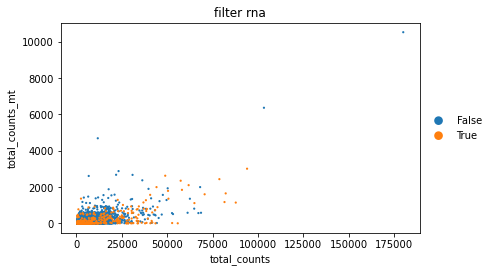

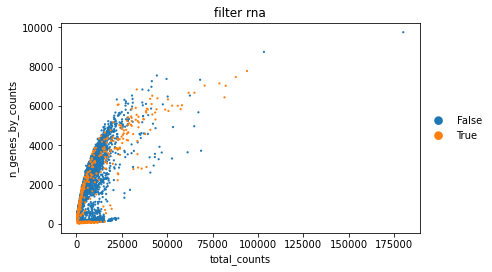

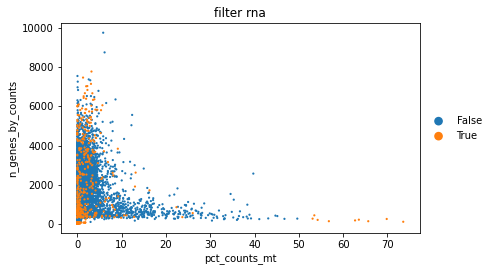

In [5]:
sc.pl.scatter(adata, x='total_counts', y='total_counts_mt', color = 'filter_rna')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color = 'filter_rna')
sc.pl.scatter(adata, x='pct_counts_mt', y='n_genes_by_counts', color = 'filter_rna')

In [6]:
pd.crosstab(adata.obs['is_doublet'], adata.obs['sample_id'])

sample_id,Men2_naive,Men_naive
is_doublet,,
False,4437,1348
True,280,72


In [7]:
# adata.write_h5ad('h5ad/combined_raw_naive.h5ad', compression = 'gzip')

In [8]:
# sc.pp.filter_cells(adata, max_genes=6000)
# sc.pp.filter_cells(adata, min_genes=200)
adata = adata[adata.obs['filter_rna'] == 'False']
sc.pp.filter_genes(adata, min_cells=3)
adata

Trying to set attribute `.var` of view, copying.


AnnData object with n_obs × n_vars = 5460 × 18627
    obs: 'sample_id', 'condition', 'site', 'scrublet_score', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'is_doublet', 'filter_rna'
    var: 'n_cells'
    uns: 'filter_rna_colors'
    layers: 'counts'

In [9]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

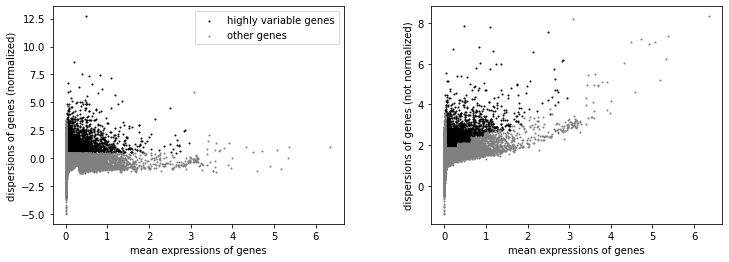

In [10]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [11]:
adata.raw = adata

In [12]:
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 5460 × 3563
    obs: 'sample_id', 'condition', 'site', 'scrublet_score', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'is_doublet', 'filter_rna'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'filter_rna_colors', 'log1p', 'hvg'
    layers: 'counts'

In [13]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

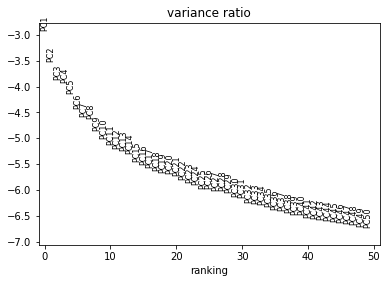

In [14]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

In [15]:
sc.external.pp.harmony_integrate(adata, key = 'sample_id')

2022-07-11 18:58:05,832 - harmonypy - INFO - Iteration 1 of 10
2022-07-11 18:58:08,937 - harmonypy - INFO - Iteration 2 of 10
2022-07-11 18:58:12,301 - harmonypy - INFO - Iteration 3 of 10
2022-07-11 18:58:15,508 - harmonypy - INFO - Converged after 3 iterations


In [16]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40, use_rep = 'X_pca_harmony')
sc.tl.leiden(adata)
sc.tl.umap(adata, min_dist=.3)

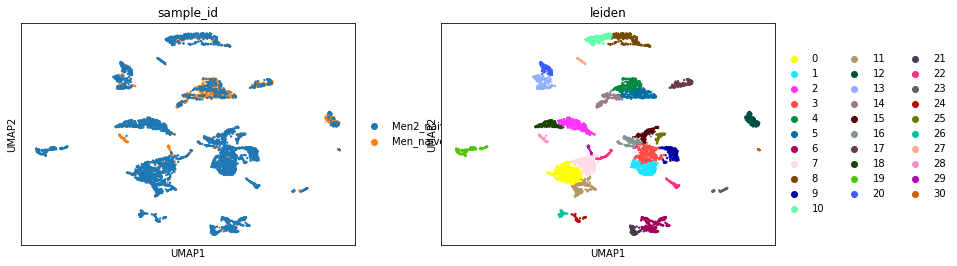

In [30]:
sc.pl.umap(adata, color=['sample_id', 'leiden',])

In [31]:
sc.tl.leiden(adata, resolution = .5, restrict_to = ('leiden', ['13']))

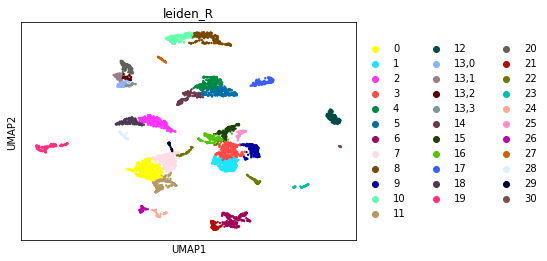

In [32]:
sc.pl.umap(adata, color=[ 'leiden_R',])

In [33]:
xdata = adata[adata.obs['leiden'].isin(['20','13'])]

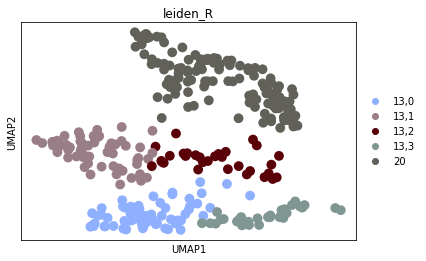

In [34]:
sc.pl.umap(xdata, color=[ 'leiden_R',])

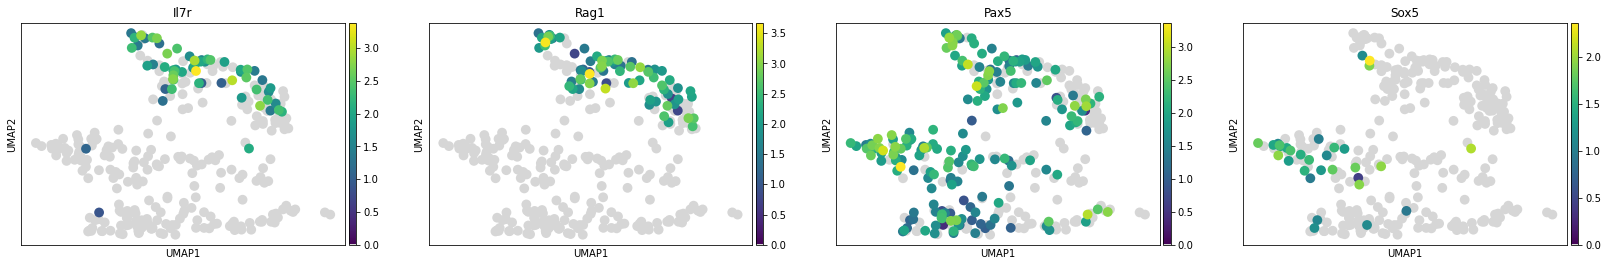

In [43]:
sc.pl.umap(xdata, color=['Il7r', 'Rag1', 'Pax5', 'Sox5'], color_map =tools.cmp())

In [36]:
sc.tl.rank_genes_groups(xdata, groupby = 'leiden_R')

Trying to set attribute `.uns` of view, copying.


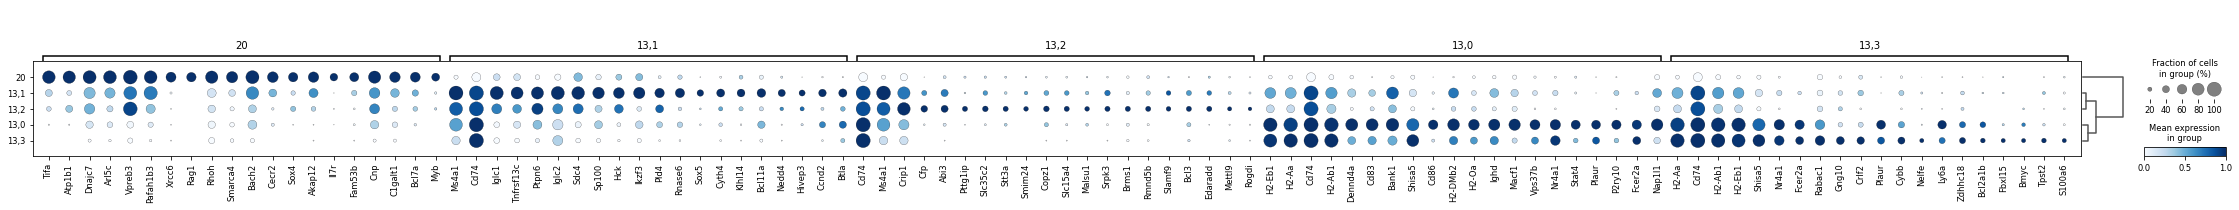

In [48]:
sc.pl.rank_genes_groups_dotplot(xdata, n_genes =20, min_logfoldchange = 1.75, standard_scale = 'var', color_map = 'Blues')

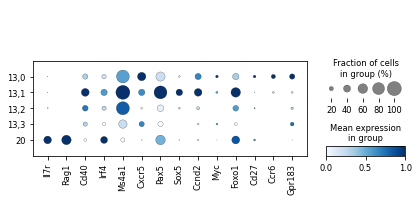

In [66]:
sc.pl.dotplot(xdata, ['Il7r', 'Rag1', 'Cd40', 'Irf4', 'Ms4a1', 'Cxcr5', 'Pax5', 'Sox5',  'Ccnd2', 'Myc', 'Foxo1', 'Cd27', 'Ccr6','Gpr183'], groupby = 'leiden_R', standard_scale = 'var', color_map = 'Blues')

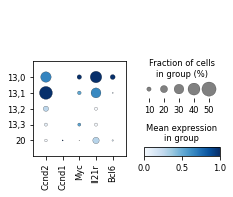

In [62]:
sc.pl.dotplot(xdata, ['Ccnd2', 'Ccnd1', 'Myc', 'Il21r', 'Bcl6'], groupby = 'leiden_R', standard_scale = 'var', color_map = 'Blues')

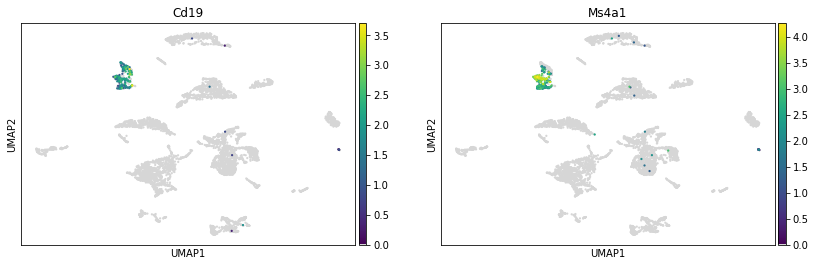

In [18]:
sc.pl.umap(adata, color = ['Cd19', 'Ms4a1'], color_map = tools.cmp(), ncols = 4, size = 20)

In [19]:
'Cxcr5', 'Aicda', 'Ms4a1',  'Mki67', 'Mzb1', 'Cxcr4', 'Cd83', 'Rag1', 'Rag2', 'Cd19' ,'Cd27', 'Ighd', 'Cr2', 'Cd22', 'Fcer2a', 'Cd38', 'Cd40'

('Cxcr5',
 'Aicda',
 'Ms4a1',
 'Mki67',
 'Mzb1',
 'Cxcr4',
 'Cd83',
 'Rag1',
 'Rag2',
 'Cd19',
 'Cd27',
 'Ighd',
 'Cr2',
 'Cd22',
 'Fcer2a',
 'Cd38',
 'Cd40')

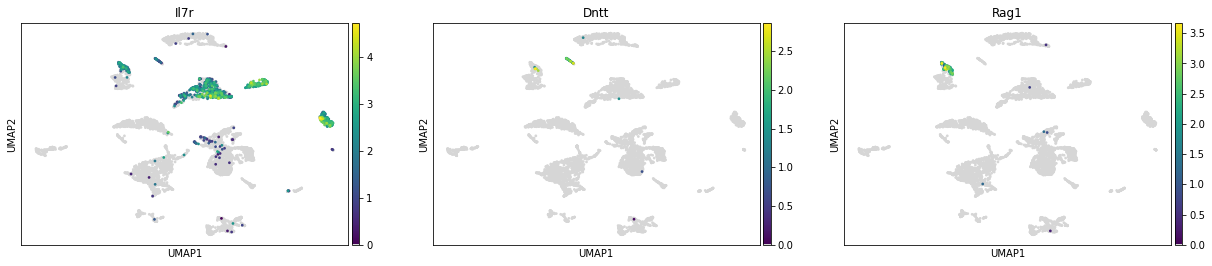

In [20]:
sc.pl.umap(adata, color = ['Il7r', 'Dntt', 'Rag1'], color_map = tools.cmp(), ncols = 3, size = 30)

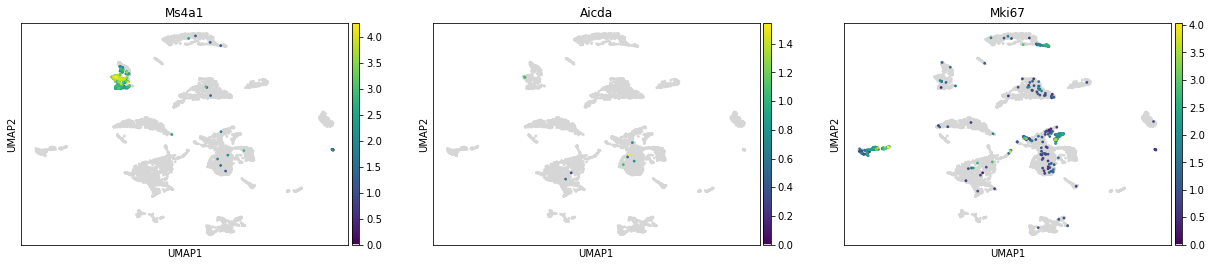

In [26]:
sc.pl.umap(adata, color = ['Ms4a1', 'Aicda', 'Mki67'], color_map = tools.cmp(), ncols = 3, size = 30)

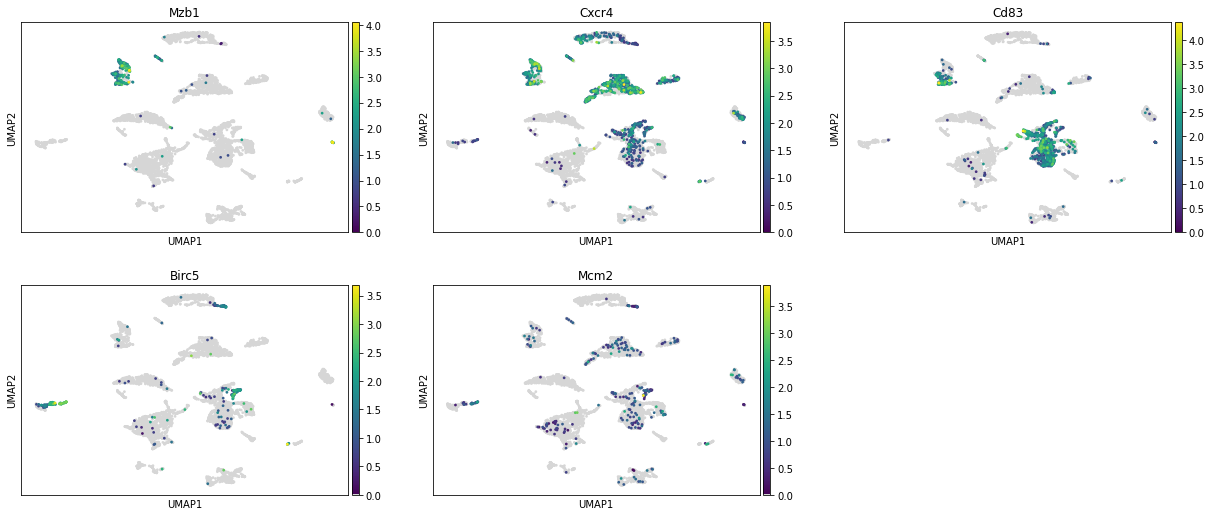

In [28]:
sc.pl.umap(adata, color = ['Mzb1', 'Cxcr4', 'Cd83', 'Birc5', 'Mcm2'], color_map = tools.cmp(), ncols = 3, size = 30)

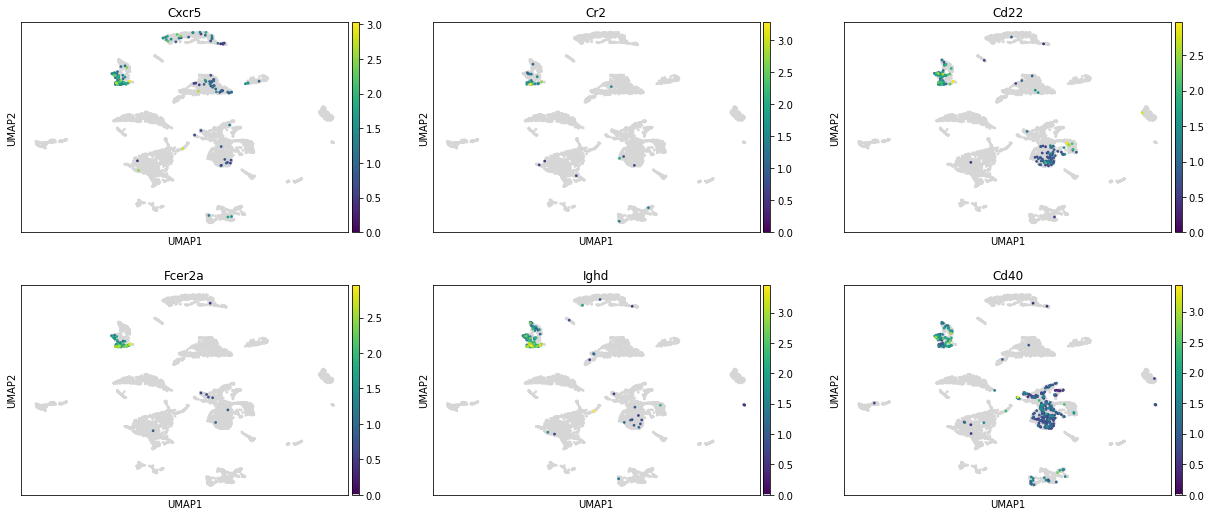

In [23]:
sc.pl.umap(adata, color = ['Cxcr5', 'Cr2', 'Cd22', 'Fcer2a', 'Ighd', 'Cd40'], color_map = tools.cmp(), ncols = 3, size = 30)

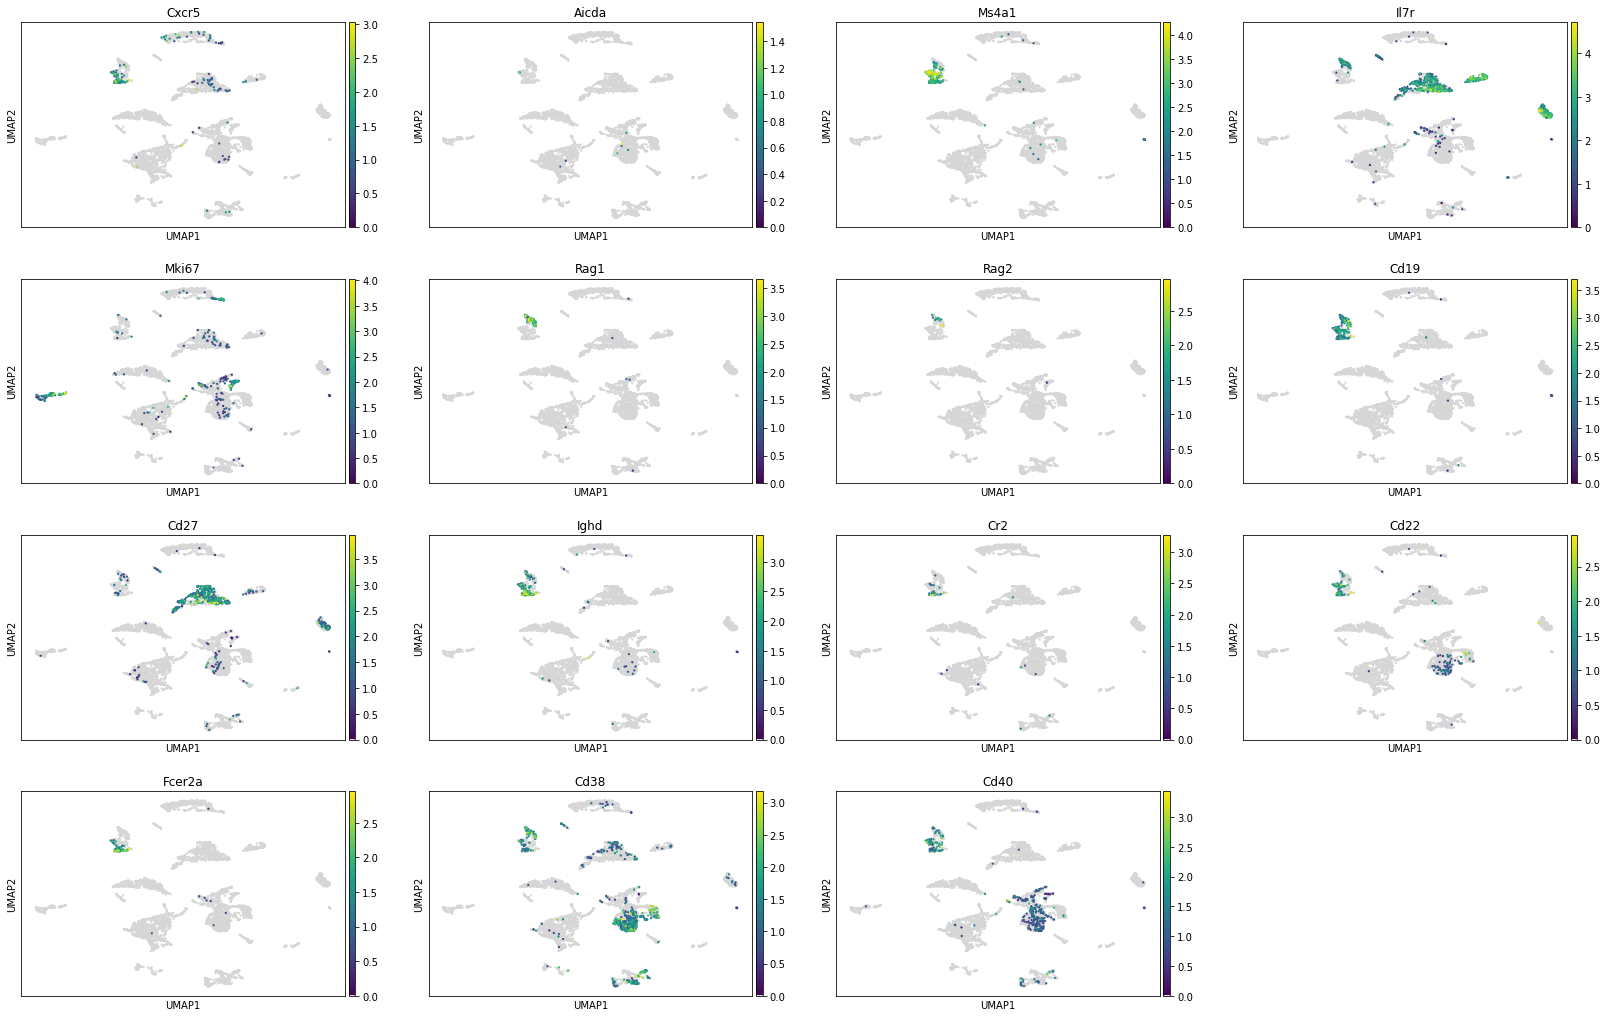

In [24]:
sc.pl.umap(adata, color = ['Cxcr5', 'Aicda', 'Ms4a1', 'Il7r', 'Mki67',  'Rag1', 'Rag2', 'Cd19' ,'Cd27', 'Ighd', 'Cr2', 'Cd22', 'Fcer2a', 'Cd38', 'Cd40'], color_map = tools.cmp(), ncols = 4, size = 20)

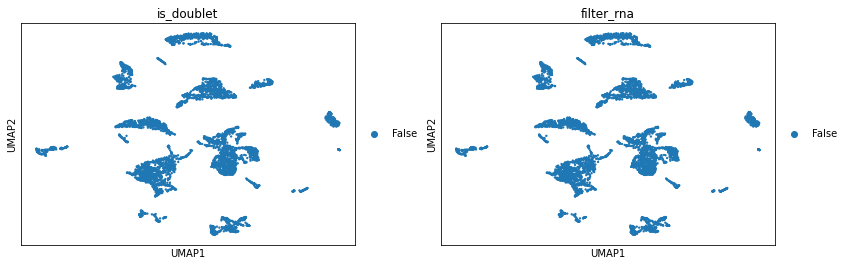

In [25]:
sc.pl.umap(adata, color = ['is_doublet', 'filter_rna'], )